# Challenge: Prototype learning

Prototypical learning is a technique that helps users make sense of patterns within data, thereby improving the interpretability of highly complex data distributions. It involves identifying representative examples (prototypes) from a given dataset, which capture the most informative characteristics of each class. This approach is especially valuable for large datasets, as it provides a more structured alternative to randomly sampling the data in order to become familiar with it. 

In this notebook, we implement the greedy algorithm to select prototypes as described in the paper *"Examples are not Enough, Learn to Criticize! Criticism for Interpretability"*, and use a kNN-based nearest prototype classifier to evaluate them compared to randomly selected samples.

In [101]:
import os
import cv2
import pickle	# Used to save variables
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm	# Used to display progress bar
import random
import torch
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
np.random.seed(22)

### Preparing the data

Images are loaded, resized, and converted to grayscale. Since we are not trying to distinguish between the different types of pneumonia, we combine the 'bacteria' and 'virus' label to one. The images are then transformed into their appropriate format (tensors) for the prototype selection class.

In [102]:
# Function to load images and labels from the dataset
def load(path, pneumonia):
    files = np.array(os.listdir(path))
    if pneumonia:
        labels = np.array([file.split('_')[1] for file in files])
    else:
        labels = np.array(['normal']*len(files))

    images = []
    for image in tqdm(files):
        image = cv2.imread(os.path.join(path, image))
		# Resize image to 200x200 px
        image = cv2.resize(image, dsize=(200,200))
		# Convert to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)
        
    images = np.array(images)
    
    return images, labels



In [103]:
print('Loading train images')
# All images are stored in _images, all labels are in _labels
norm_images, norm_labels = load(f"C:\\Users\\SaahitiP\\Desktop\\ML4HC\\chest_xray\\train\\NORMAL", False)
pneu_images, pneu_labels = load(f"C:\\Users\\SaahitiP\\Desktop\\ML4HC\\chest_xray\\train\\PNEUMONIA", True)
# Put all train images to X_train 
X_train = np.append(norm_images, pneu_images, axis=0)
#labels to y_train
y_train = np.append(norm_labels, pneu_labels)

print('Loading test images')
norm_images_test, norm_labels_test = load(f"C:\\Users\\SaahitiP\\Desktop\\ML4HC\\chest_xray\\test\\NORMAL", False)
pneu_images_test, pneu_labels_test = load(f"C:\\Users\\SaahitiP\\Desktop\\ML4HC\\chest_xray\\test\\PNEUMONIA", True)
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)

print('Loading val images')
norm_images_val, norm_labels_val = load(f"C:\\Users\\SaahitiP\\Desktop\\ML4HC\\chest_xray\\val\\NORMAL", False)
pneu_images_val, pneu_labels_val = load(f"C:\\Users\\SaahitiP\\Desktop\\ML4HC\\chest_xray\\val\\PNEUMONIA", True)
X_val = np.append(norm_images_val, pneu_images_val, axis=0)
y_val = np.append(norm_labels_val, pneu_labels_val)


# we dont want to distinguish between different types of pneumonia, so the label 'bacteria' and 'virus' are replaced by 'pneumonia'
y_train[y_train == 'bacteria'] = 'pneumonia'
y_train[y_train == 'virus'] = 'pneumonia'

y_test[y_test == 'bacteria'] = 'pneumonia'
y_test[y_test == 'virus'] = 'pneumonia'

y_val[y_val == 'bacteria'] = 'pneumonia'
y_val[y_val == 'virus'] = 'pneumonia'

print(np.unique(y_train, return_counts=True))

Loading train images


100%|██████████| 3875/3875 [00:30<00:00, 125.43it/s]


Loading test images


100%|██████████| 390/390 [00:02<00:00, 144.48it/s]


Loading val images


100%|██████████| 8/8 [00:00<00:00, 145.87it/s]

(array(['normal', 'pneumoni'], dtype='<U8'), array([1341, 3875], dtype=int64))


In [104]:
print('Preparing data...')

# convert to tensors
images_tensor = torch.tensor(X_train, dtype=torch.float32)
images_tensor = images_tensor.view(images_tensor.shape[0], -1)  # Flatten the images

labels_numeric = np.where(y_train == 'normal', 0, 1)
labels_tensor = torch.tensor(labels_numeric, dtype=torch.long)

sort_indices = labels_tensor.argsort() 
X_train_all = images_tensor[sort_indices, :]
y_train_all = labels_tensor[sort_indices]

#do the same for the validation set
images_tensor_val = torch.tensor(X_val, dtype=torch.float32)
images_tensor_val = images_tensor_val.view(images_tensor_val.shape[0], -1)  # Flatten the images

labels_numeric_val = np.where(y_val == 'normal', 0, 1)
labels_tensor_val = torch.tensor(labels_numeric_val, dtype=torch.long)

sort_indices_val = labels_tensor_val.argsort() 
X_val_all = images_tensor_val[sort_indices_val, :]
y_val_all = labels_tensor_val[sort_indices_val]


#do the same for the test set
test_images_tensor = torch.tensor(X_test, dtype=torch.float32)
test_images_tensor = test_images_tensor.view(test_images_tensor.shape[0], -1)  # Flatten the images

test_labels_numeric = np.where(y_test == 'normal', 0, 1)
test_labels_tensor = torch.tensor(test_labels_numeric, dtype=torch.long)

#print(X_train_)
#print(y_train_)
# Combine original train and validation datasets
#combined_images = np.concatenate((X_train, X_val), axis=0)
#combined_labels = np.concatenate((y_train, y_val), axis=0)

# Perform stratified split with 9:1 ratio
#X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(
    #combined_images, combined_labels, test_size=0.1, stratify=combined_labels, random_state=42
#)

print('Done.')


Preparing data...
Done.


## Part 1: The Nearest Prototype Classifier 

Following section 5 of the paper, we employ a 1-nearest-neighbor classifier that uses a normalized RBF kernel.
Under this assumption, the Hilbert space distance induced by the kernel can be simplified, and it’s sufficient to measure the pairwise kernel similarity when searching for the nearest prototype. To implement this, we create a custom class that inherits from Sklearn’s KNeighborsClassifier and build a 1NN classifier with the RBF similarity metric, which we fit on random samples from the training data. $\gamma$ and the number of samples were finetuned for the MMD-Critic in later steps. and selected as 0.0001 and 80 respectively.

In [105]:
class RBFKernel1NN(KNeighborsClassifier):
    def __init__(self, tune, **kwargs):
        super().__init__(n_neighbors=1, **kwargs)
        self.tune = tune

    def rbf_kernel(self, X1, X2):
        X1 = torch.tensor(X1, dtype=torch.float)
        X2 = torch.tensor(X2, dtype=torch.float)
        
        K = torch.cdist(X1, X2)
        K.pow_(2).mul_(-self.tune).exp_()
        return K

    def _pairwise(self, X, Y=None):
        if Y is None:
            Y = X
        kernel_similarity = self.rbf_kernel(X, Y)
        return kernel_similarity

# class that inherits from KNN, builds 1NN classifier with RBF kernel
class NNClassifier:
    model=None

    def __init__(self):
        pass

    def build_model(self, trainX, trainy, gamma_t):
        print(f"building model using {len(trainy)} points with gamma={gamma_t}")
        self.model = RBFKernel1NN(tune=gamma_t) 
        self.model.fit(trainX, trainy)

    def classify(self, testX, testy):
        predicted_labels = self.model.predict(testX)

        accuracy = accuracy_score(testy, predicted_labels)
        report = classification_report(testy, predicted_labels)

        return accuracy, report

#### Classifier on random prototypes

In [106]:
# Random selection of subset of data
random_indices = torch.randperm(images_tensor.shape[0])[:80]
random_prototypes = images_tensor[random_indices]
random_prototype_labels = labels_tensor[random_indices]
random_prototypes_np = random_prototypes.numpy()
random_prototype_labels_np = random_prototype_labels.numpy()

# Train the 1-nearest neighbor classifier using the randomly selected prototypes
classifier_random = NNClassifier()
classifier_random.build_model(random_prototypes_np, random_prototype_labels_np, None)

# Prediction for test set and computing classification performance
accuracy, report = classifier_random.classify(test_images_tensor, test_labels_tensor)
print("\n")
print("accuracy", accuracy)
print("\n")
print(report)

building model using 80 points with gamma=None


accuracy 0.6971153846153846


              precision    recall  f1-score   support

           0       0.80      0.26      0.39       234
           1       0.68      0.96      0.80       390

    accuracy                           0.70       624
   macro avg       0.74      0.61      0.59       624
weighted avg       0.73      0.70      0.64       624



## Part 2: The MMD-Critic Class

This class is designed to select representative prototypes from a given dataset. It takes a tensor X representing the input data and a tensor y representing its labels, and consists of several methods:

1. **simple_rbf_kernel** computes the RBF kernel matrix with a chosen $\gamma$
2. **Jb** calculates the $J_b(S)$ score for a given set of selected prototypes
3. **select_prototypes** implements greedy selection of prototypes by iteratively selecting the prototypes with the highest $J_b(S)$ score. 
This method iterates through all candidate prototypes and computes the $J_b(S)$ value using the **Jb** function at every iteration. It adds the prototype with the highest $J_b(S)$ value to the selected set, since the highest $J_b(S)$ value corresponds to the largest increase. 

In [119]:
class PrototypeSelection:
    def __init__(self, X: torch.Tensor, y:torch.Tensor) -> None:
        self.sort_indices = y.argsort()
        self.X = X[self.sort_indices, :]
        self.y = y[self.sort_indices]

    def simple_rbf_kernel(self, gamma:float=None):
        if gamma is None:
            gamma = 1.0 / self.X.shape[1]
            print(f'default gamma={gamma} selected!')
        K = torch.cdist(self.X, self.X)
        K.pow_(2).mul_(-gamma).exp_()
        self.K = K
        
    
    def Jb(self, K: torch.Tensor, selected: torch.Tensor):
        n = K.shape[0]
        num_prototypes = len(selected)
        
        # first term: average kernel similarity between the data points in X and the prototypes in S
        term1 = (2 / (n * num_prototypes)) * K[:, selected].sum()
        
        # second term: average kernel similarity between the prototypes themselves (in S)
        term2 = K[selected, :][:, selected].sum() / (num_prototypes**2)
        
        # Compute Jb(S)
        jb_s = term1 - term2
        
        return jb_s

    # iterate through all candidate prototypes and compute Jb(S) using the Jb function at every iteration, adding the prototype with the 
    # highest Jb(S) value to the selected set, since the highest Jb(S) value corresponds to the largest increase.
    def select_prototypes(self, K: torch.Tensor, num_prototypes: int):
        n = K.shape[0]
        selected = []

        for _ in range(num_prototypes):
            max_jb = float('-inf')
            best_sample_index = None

            for i in range(n):
                if i not in selected:
                    temp_selected = selected + [i]
                    jb = self.Jb(K, temp_selected)
                    if jb > max_jb:
                        max_jb = jb
                        best_sample_index = i

            selected.append(best_sample_index)

        return selected

#### Theory: The greedy algorithm

Recall that the steps for greedily selecting prototypes as a set S are the following:

    1. Initialize the set S as an empty set.
    2. While the size of the set S is less than num_prototypes:
        a. For each element i that is not already in S, compute the change in the set function value when adding i to S (fi = F(S ∪ i) - F(S)).
        b. Add the element with the maximum fi value to the set S.
    3. Return the set S.

And that the function  $J_b(S)$ is defined in section 3 as follows:

$J_b(S)$ = [average kernel similarity between all data points in X] - $[MMD^2]$, 

where $MMD^2$ consists of two parts: 1) The average kernel similarity between the data points in X and the prototypes in S and 2) The average kernel similarity between the prototypes in S.

In our case, $J_b(S)$ fulfills the submodularity condition that the set function F requires, as long as the chosen kernel is diagonally dominant. According to Corollary 3, the RBF Kernel fulfills this property for sufficiently large $\gamma$. Therefore, we can employ the greedy algorithm for selecting prototypes by finetuning $\gamma$. 



This is an example to show how we compute prototypes of a dataset using the PrototypeSelection class, and how we visualize them.

In [120]:
gamma = 0.0001 # This value was finetuned in a cross-validation loop
num_prototypes = 80 # This value was finetuned in a cross-validation loop

print('Computing prototypes...')
# Initialize object of class 
d_train = PrototypeSelection(X_train_all, y_train_all)
# Precompute kernel matrix
d_train.simple_rbf_kernel(gamma)
# Select prototypes via greedy algorithm
prototype_indices = d_train.select_prototypes(d_train.K, num_prototypes)
prototypes = d_train.X[prototype_indices]
prototype_labels = d_train.y[prototype_indices]
print('Done!')

Computing prototypes...
Done!


#### Visualizing healthy and unhealthy prototypes

Plotting healthy prototypes...
Done.
Plotting unhealthy prototypes...
Done.


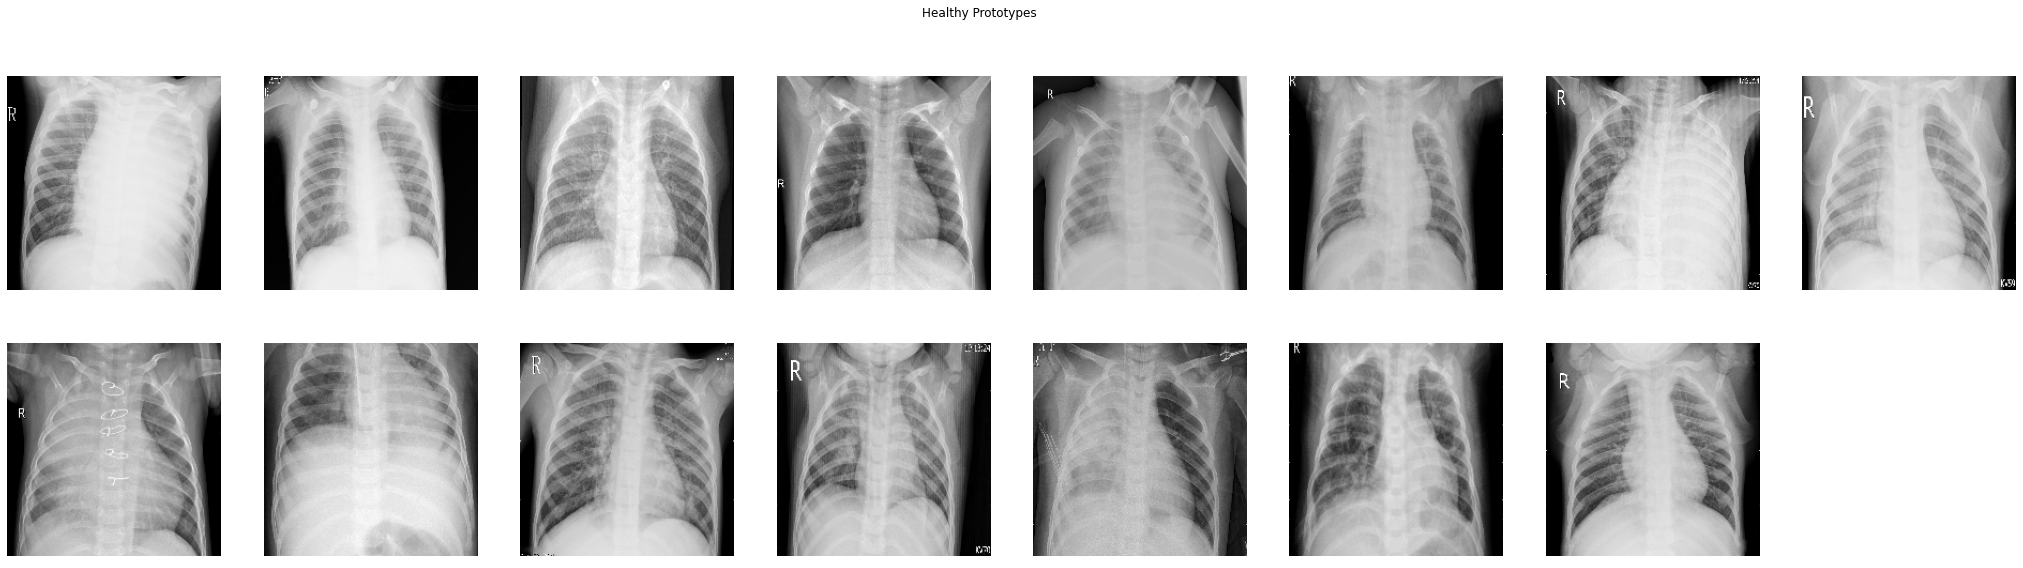

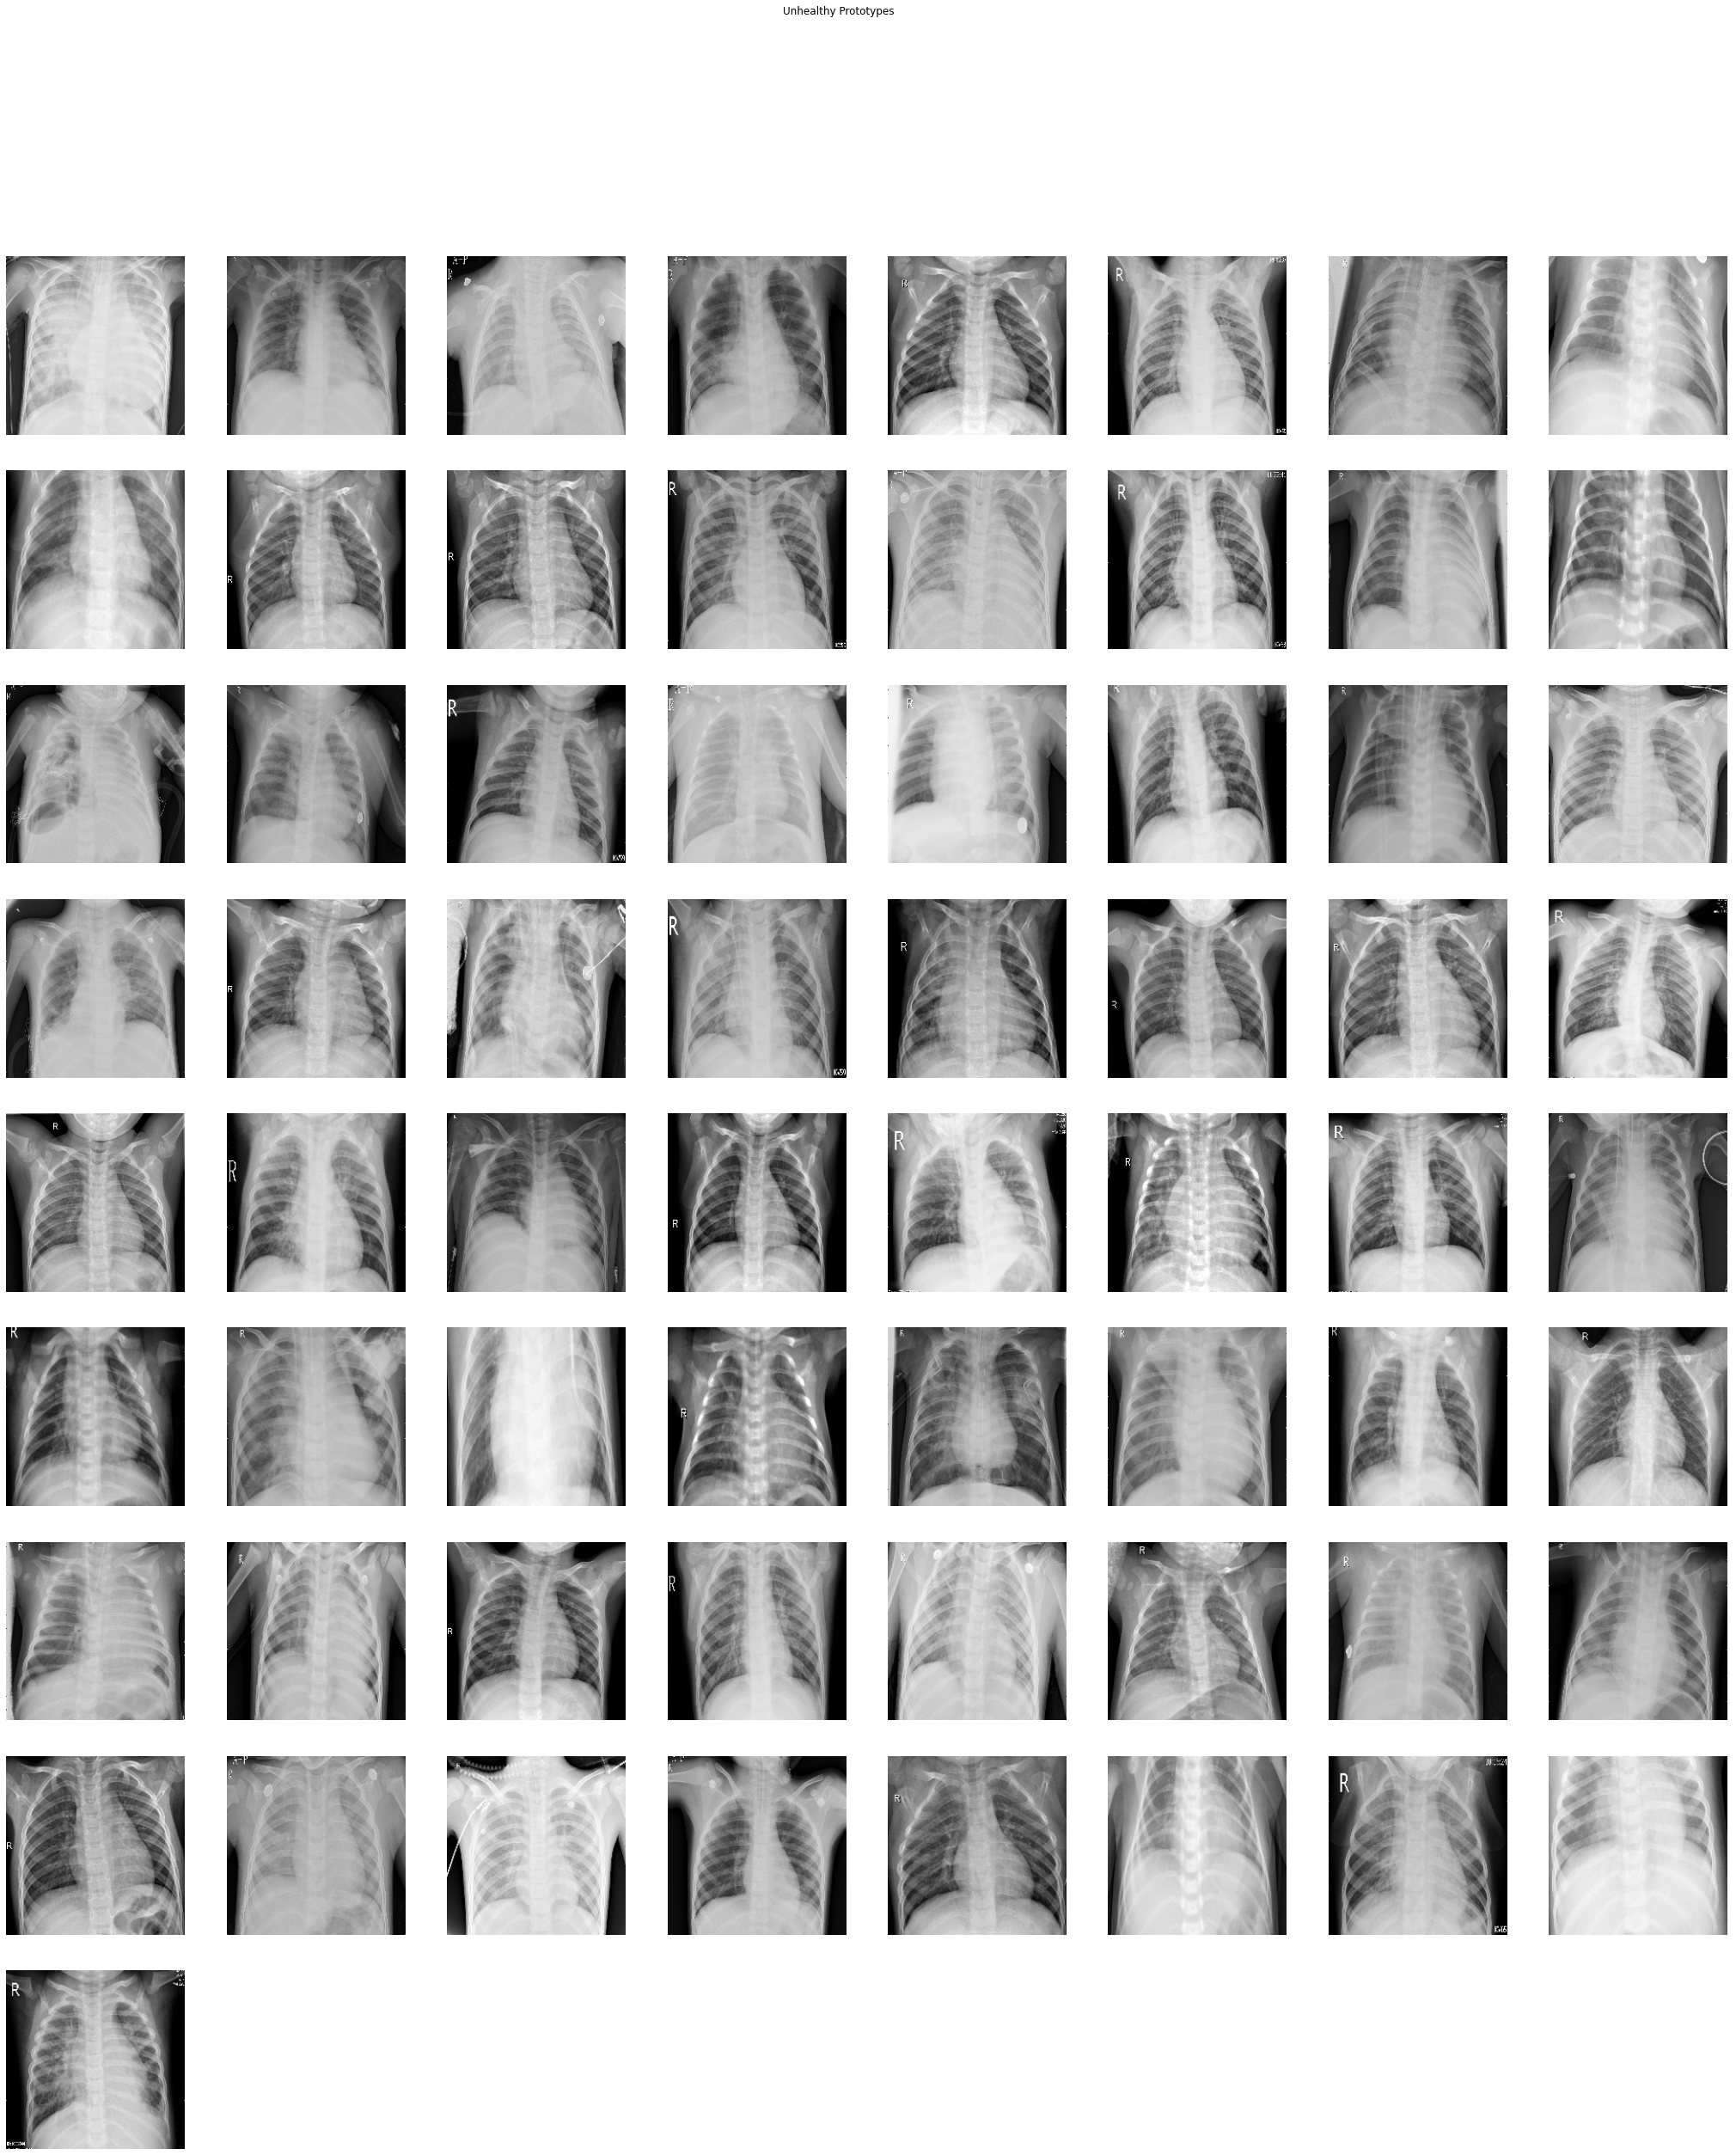

In [127]:
prototypes_sorted = prototypes[prototype_labels.argsort()]
prototype_labels = prototype_labels[prototype_labels.argsort()]
healthy_prototypes = prototypes_sorted[prototype_labels == 0]
unhealthy_prototypes = prototypes_sorted[prototype_labels == 1]

healthy_indices = [2, 7, 9, 10, 12]
unhealthy_indices = [8, 29, 35, 40, 63]

selection_healthy = healthy_prototypes[healthy_indices]
selection_unhealthy = unhealthy_prototypes[unhealthy_indices]

num_cols = 8
num_rows_healthy = math.ceil(healthy_prototypes.shape[0] / num_cols)
num_rows_unhealthy = math.ceil(unhealthy_prototypes.shape[0] / num_cols)


# Plot healthy prototypes
print('Plotting healthy prototypes...')
fig1, axes1 = plt.subplots(num_rows_healthy, num_cols, figsize=(36, num_rows_healthy * 4.5))
for i, axis in enumerate(axes1.ravel()):
    if i >= healthy_prototypes.shape[0]:
        axis.axis('off')
        continue
    axis.imshow(healthy_prototypes[i].view(200, 200).numpy(), cmap='gray')
    axis.axis('off')
fig1.suptitle(f'Healthy Prototypes')
print('Done.', flush=True)

# Plot unhealthy prototypes
print('Plotting unhealthy prototypes...')
fig2, axes2 = plt.subplots(num_rows_unhealthy, num_cols, figsize=(36, num_rows_unhealthy * 4.5))
for i, axis in enumerate(axes2.ravel()):
    if i >= unhealthy_prototypes.shape[0]:
        axis.axis('off')
        continue
    axis.imshow(unhealthy_prototypes[i].view(200, 200).numpy(), cmap='gray')
    axis.axis('off')
fig2.suptitle(f'Unhealthy Prototypes')
print('Done.', flush=True)

### 1NN classifier on MMD-selected prototypes

The intuition behind this task is rooted in the fact that prototypes chosen by the MMD-Critic are selected in an unsupervised manner, merely aiming to be representative and informative examples of the data points. Consequently, if these prototypes effectively capture the essence of the data distribution, they should also be effective when used in nearest prototype classification. 

We start by finetuning the hyperparameters $\gamma$ and number of prototypes. We iterate through the range of hyperparameter values, computing the prototypes according to the current hyperparameters, fit a 1NN classifier on the selected prototypes and validate its performance.

We then select $\gamma$ and number of prototypes which result in the best performance, refit the 1NN classifier with the prototypes produced by using them, and report its performance on the test set

#### Finetuning 

In [128]:
# Define the range of gamma values
gamma_range = [0.0001, 0.026] #0.0005
#alltestm = np.array(
       # [200, 100, 83, 80, 78, 70, 50, 40, 32])
alltestm = np.array(
        [70, 80])  # test using these number of prototypes


best_gamma = None
best_m = None
best_val_performance = float("-inf")

for g in gamma_range:
    for testm in alltestm:
        print(f"Testing gamma = {g} and m = {testm} ")
        
        # Compute RBF kernel with the current gamma value
        d_train = PrototypeSelection(X_train_all, y_train_all)
        d_train.simple_rbf_kernel(g)

        # Select the prototypes 
        prototype_indices = d_train.select_prototypes(d_train.K, num_prototypes) # For exhaustive approach

        # Build 1nn model with the current prototypes
        knn_classifier = NNClassifier()
        knn_classifier.build_model(d_train.X[prototype_indices], d_train.y[prototype_indices], g)

        # Evaluate on validation set
        accuracy_curr, report = knn_classifier.classify(test_images_tensor, test_labels_tensor)

        print("\n")
        print("accuracy", accuracy_curr)
        print("\n")

        # Update the best gamma and testm if the current performs better
        if accuracy_curr > best_val_performance:
            best_gamma = g
            best_m = testm
            best_val_performance = accuracy_curr

print(f"Best gamma: {best_gamma}, best m ={best_m}, validation performance: {best_val_performance}")

Testing gamma = 0.0001 and m = 70 
building model using 70 points with gamma=0.0001


accuracy 0.7660256410256411


Testing gamma = 0.0001 and m = 80 
building model using 80 points with gamma=0.0001


accuracy 0.7724358974358975


Testing gamma = 0.026 and m = 70 
building model using 70 points with gamma=0.026


accuracy 0.7708333333333334


Testing gamma = 0.026 and m = 80 
building model using 80 points with gamma=0.026


accuracy 0.7612179487179487


Best gamma: 0.0001, best m =80, validation performance: 0.7724358974358975


#### Classification

In [129]:
# Compute prototypes with the best gamma value on the training set
d_train.simple_rbf_kernel(best_gamma)
print('Computing prototypes...')
prototype_indices = d_train.select_prototypes(d_train.K, best_m)

# Evaluate classifier on the test set to obtain the final performance metric
classifier = NNClassifier()
classifier.build_model(d_train.X[prototype_indices], d_train.y[prototype_indices], best_gamma)
accuracy, report = classifier.classify(test_images_tensor, test_labels_tensor)
accuracy, report = classifier.classify(test_images_tensor, test_labels_tensor)
print("\n")
print("Final accuracy", accuracy)
print("\n")
print(report)


Computing prototypes...
building model using 80 points with gamma=0.0001


Final accuracy 0.7724358974358975


              precision    recall  f1-score   support

           0       0.81      0.52      0.63       234
           1       0.76      0.93      0.84       390

    accuracy                           0.77       624
   macro avg       0.78      0.72      0.73       624
weighted avg       0.78      0.77      0.76       624

